## Identifying HGT Events

#### Friday 06/26/2020 - Catching up my lab notebook

The first steps to finding putative HGT events in Wolbachia necessitate creating custom databases and working with BLAST. The following notes and protocols were performed prior to this date and are just now being recorded.
These were the commands used for the BLAST protocol to generate putative HGT events.

In [ ]:
makeblastdb -in all_wolbachia_genomes.faa -out wolbachia_db -title wolbachia_db -dbtype prot

find . -name "*.faa" | parallel -j 8 "blastp -query {} -out {}.out -db /Scratch/smnieves/databases/wolbachia_db/wolbachia_db -num_threads 8 -outfmt 6"

FilterBlast.py -dir /home/smnieves/arthropod_genomes/genbank_prot/ -percID 90 -len_align 150

The BLAST results were filtered for arthropod (potentially horizontally transferred) proteins that had at least 150 aligned amino acids and 90% sequence identity with a Wolbachia protein, in order to obtain sufficiently recent HGT events (using FilterBlast.py). The query column was then taken from the filtered BLAST output and duplicates were removed, to arrive at 1673 putative horizontally transferred proteins (arthqueries.txt). **The taxonomic information on BLAST hits is shown below.**

| Scientific Name                                 | Common Name                             | Number of HGT protein hits |
|-------------------------------------------------|-----------------------------------------|----------------------------|
| Wolbachia Endosymbiont of Armadillidium vulgare | Wolbachia (endosymbiont of pill-bug)    | 1206                       |
| Armadillidium vulgare                           | Pill-bug, roly-poly                     | 12                         |
| Vollenhovia emeryi                              | Ant species from East Asia              | 170                        |
| Trichonephila clavipes                          | Golden silk orb-weaver spider           | 127                        |
| Cinara cedri                                    | Cedar bark aphid                        | 70                         |
| Laodelphax striatellus                          | Small brown planthopper                 | 29                         |
| Formica exsecta                                 | Narrow-headed ant                       | 20                         |
| Acromyrmex echinatior                           | Panamanian leaf-cutter ant              | 13                         |
| Wasmannia auropunctata                          | Electric ant, little fire ant           | 7                          |
| Rhagoletis zephyria                             | Snowberry fruit fly                     | 6                          |
| Drosophila ananassae                            | Fruit fly in the Melanogaster group     | 3                          |
| Ceratina calcarata                              | Spurred ceratina, carpenter bee species | 2                          |
| Cryptotermes secundus                           | West Indian drywood termite             | 2                          |
| Solenopsis invicta                              | Red imported fire ant                   | 1                          |
| Drosophila eugracilis                           | Fruit fly in the Melanogaster group     | 1                          |
| Sipha flava                                     | Yellow sugarcane aphid                  | 1                          |

Next, we wanted to validate the HGT events we potentially uncovered through BLAST. To do this we mapped WGS reads to the reference genome of each arthropod and checked the coverage of Wolbachia-transferred exonic regions vs. the coverage of similarly sized exonic regions in the host.

In [ ]:
import CovCheck
CovCheck.speciesHisto()
# this means google drive syncing works

## Associating Protein and Gene IDs

#### Friday 06/26/2020

First I converted all of the GFF files I used for STAR alignment into GTF format. I did it this way so there would be consistent naming conventions across my analysis, as some of the GTF files available directly from NCBI had different identifiers for genes and chromosomes. I used GFF because the NCBI GTF files were not playing nice with STAR. This results in .gff.gtf files; I kept the names this way to distinguish between GTF files I made from GFF conversions and GTF files I may have downloaded directly from NCBI with different information.

In [ ]:
find */ -name "*.gff" -exec gffread -EFT {} -o {}.gtf \;

Because in the subsequent step there was no way to extract the protein IDs when I calculate TPM for each gene using TPMCalculator, I needed to find a way to relate gene IDs with protein IDs (to be honest I had been putting this off for a while). I found a pretty convenient awk solution from biostars to do this, and adapted it to my needs. It parses the GTF file and looks for gene_id and protein_id attributes in the same line and creates a document that associates them. This is done for the entire GTF file in every organism's folder.

In [ ]:
for dir in *
do
awk '{for (i = 1; i <= NF; i++) {
        if ($i ~ /Parent|protein_id/ && $i !~ /orig/) {
            printf "%s ", $(i+1)
        }
    }
    print ""
}' $dir/*.gff | sed -e 's/"//g' -e 's/;//g' -e 's/ /\t/' | sort -u -k2,2 > $dir/prot_gene_ids.txt
done

The next thing I wanted to do was have a list of all protein and gene IDs for HGT events concatenated for every organism. I have the protein IDs already, so I concatenated together the gene and protein IDs for the whole GTF file, filtered for only genes that corresponded to my BLAST hit proteins, and put the gene_ids.txt file in the results folder.

In [ ]:
rm results/prot_gene_ids.txt
cat */prot_gene_ids.txt | grep -Ff ~/bin/arth_queries.txt > results/prot_gene_ids.txt

For some reason this only results in 568 gene IDs when I know there are 1673 proteins. This is concerning so I'm going to look into this further. Actually I think I know why this might be. Armadillidium vulgare is the only organism that has two different assemblies and therefore two different GTF files that I'm analyzing. It also accounts for a lot of genes. I think my awk command is overwriting one of the prot_gene_ids.txt files because they would have the same name in the same folder. So I'll do this command individually on each GTF for this organism. I also appended the two ID files together in the end, and reran the above command. Ok, so now I have 1774 gene IDs, which is too many. After removing duplicates with uniq, there are 1490 gene IDs. When I remove duplicates using sort on the list of proteins, I get 1635, which is almost there. When I remove duplicates using sort on the list of genes, I get 1632 which is more comparable to the protein count. I realized that Drosophila ananassae has two assemblies as well, so I went back and did the awk part separately, so now there are 1638 unique proteins and 1635 unique genes found in the GTF file for HGT events.
**I actually realized that the awk script I had written previously did not account for some weird things going on in the GTF files where more than one field had the string** protein_id **in it. So the I modified the awk script to the one above, which works well.**

#### Sunday 06/28/2020 - Finalizing prot_gene_ids.txt
I've been looking around some database accession / ID converters but it seems there's no solutions for the proteins I have here. The reason is that some of the proteins are predictions from CDS, so NCBI doesn't link any annotated genes to them. The GTF files have gene IDs that correspond to the protein IDs but when you pop the gene ID into NCBI it returns a page about the protein. So I guess I will have to settle for using those "gene IDs that are not really gene IDs". I still have to verify that I get the correct number of gene IDs for each organism, so I will be doing that separately for each organism. **It seems that some GTF files have proteins that have the correct information except the protein ID is messed up. I verified that with Cinara cedri, where all of the information is correct for this** [annotation](https://pmlegacy.ncbi.nlm.nih.gov/protein/VVC27533.1) **except the** protein_id **is listed as VVC27534.1 instead of VVC27533.1. I'll have to manually correct this.**

VVC27533.1 and VVC27534.1 share the same gene CINCED_3A012149. Maybe this causes the confusion. Additionally, I just checked and it looks like although there are 1673 protein accessions, only 1670 are recognized by Batch Entrez and NCBI. So I'm moving forward with 1670, though at some point I should figure out what the 3 anomalous records are.

| Organism                                        | Number of Proteins | Number of gene_ids in GTF |
|-------------------------------------------------|--------------------|---------------------------|
| Wolbachia Endosymbiont of Armadillidium vulgare | 1206               | 1206                      |
| Armadillidium vulgare                           | 12                 | 12                        |
| Vollenhovia emeryi                              | 170                | 170                       |
| Trichonephila clavipes                          | 127                | 127                       |
| Cinara cedri                                    | 70                 | 69                        |
| Laodelphax striatellus                          | 29                 | 29                        |
| Formica exsecta                                 | 20                 | 20                        |
| Acromyrmex echinatior                           | 13                 | 13                        |
| Wasmannia auropunctata                          | 7                  | 7                         |
| Rhagoletis zephyria                             | 6                  | 6                         |
| Drosophila ananassae                            | 3                  | 3                         |
| Ceratina calcarata                              | 2                  | 2                         |
| Cryptotermes secundus                           | 2                  | 0                         |
| Solenopsis invicta                              | 1                  | 1                         |
| Drosophila eugracilis                           | 1                  | 1                         |
| Sipha flava                                     | 1                  | 1                         |

## TPMCalculator Stuff

#### Friday 06/30/2020

For the record I worked on this project between Friday and Tuesday, but I was just making adjustments and figuring things out pertaining to the above script stuff so I didn't add a new day. I did find out that although there are **1673** protein accessions, **3 are anomalous**. I will proceed with the non-anomalous ones for now. It also appears that the 1 Cinara cedri accession and 2 Cryptotermes secundus accessions are somehow not in the GTF files. This makes sense because I didn't find anything for this species in the cov_check analysis I did. There is only 1 assembly available so this is suspect. *I'm going to move on with what I have for the sake of time.* So here is how I am calculating TPM.

In [ ]:
# some features in .gff.gtf file may not have gene_id and that messes up TPMCalculator
sed '/gene_id/!d' *.gtf > new_file

for dir in *_*
do
        TPMCalculator -g $dir/*.gtf -d $dir -p
done

#### Wednesday 7/01/2020 - Creating a JitterPlot
This is the test run for figuring out the JitterPlot specifics before I run my TPM data through it. I'm just going to randomly generate data and see how it looks.

['#3c1642', '#7d2e8a', '#086375', '#0fb1d2', '#1dd3b0', '#93f0de', '#d7263d', '#e77484', '#a288e3', '#d8cdf4', '#f6ae2d', '#f9d38a', '#fa7921', '#fcaa73', '#ee4266', '#f58fa5', '#5b3000', '#b86200', '#607744', '#93ad71']
['a_echinatior\nERR034191', '', 'a_vulgare\nSRR1324808', '', 'c_cedri\nERR3447770', '', 'f_exsecta\nDRR118169', '', 's_invicta\nSRR8570229', '', 't_clavipes\nSRR5139361', '', 'v_emeryi\nDRR030162', '', 'w_auropunctata\nDRR029092', '']


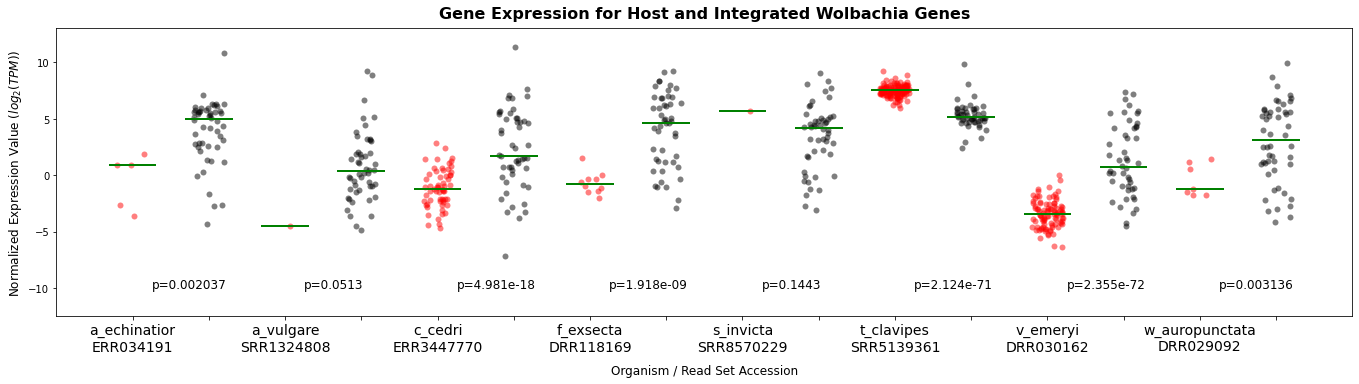

In [100]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

__author__ = 'Serafina Nieves'
__email__ = 'smnieves@ucsc.edu'

import pandas as pd
import argparse
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
import numpy as np
import os
import random

# change dimensions of the entire figure
figureHeight = 5.25
figureWidth = 20

plt.figure(figsize=(figureWidth, figureHeight))

mainPanelWidth = 18
mainPanelHeight = 4

mainPanel = plt.axes([0.08, 0.15, mainPanelWidth / figureWidth, mainPanelHeight / figureHeight])

arth_genes = []
with open("arth_gene_ids.txt") as file:
    for line in file:
        arth_genes.append(line.strip())
        
species_dict = {"a_vulgare": "armadillidium vulgare", "a_echinatior": "acromyrmex echinatior", "c_cedri": "cinara cedri", "c_calcarata": "ceratina calcarata", "d_ananassae": "drosophila ananassae", "d_eugracilis": "drosophila eugracilis", "f_exsecta": "formica exsecta", "r_zephyra": "rhagoletis zephyria", "s_flava": "sipha flava", "s_invicta": "solenopsis invicta", "t_clavipes": "trichonephila clavipes", "v_emeryi": "vollenhovia emeryi", "w_auropunctata": "wasmannia auropunctata", "l_striatellus": "laodelphax striatellus"}

        
#print(arth_genes)
SRA_dict = {}
color_list = ["#3c1642","#086375","#1dd3b0","#d7263d","#a288e3","#f6ae2d","#fa7921","#ee4266","#5b3000","#607744"]
color_list2 = ["#7d2e8a","#0fb1d2","#93f0de","#e77484","#d8cdf4","#f9d38a","#fcaa73","#f58fa5","#b86200","#93ad71"]
color_pairs = color_list + color_list2
color_pairs[::2] = color_list
color_pairs[1::2] = color_list2
print(color_pairs)


def readData():
    with open(filename) as tpm_file:
        tpm_df = pd.read_csv(tpm_file, engine='python', header=0, sep='\t')
        hgt_df = tpm_df[tpm_df['Gene_Id'].isin(arth_genes)]
        host_df = tpm_df[~tpm_df['Gene_Id'].isin(arth_genes)]
        host_df_sample = tpm_df[~tpm_df['Gene_Id'].isin(arth_genes)].sample(50)
        #print(filename, hgt_df)
        
        mwu_values = mannwhitneyu(hgt_df['TPM'], host_df['TPM'])
    
#         outdf.drop_duplicates(subset="Gene_Id", keep="first")
#         all_outfile.write(outdf.to_csv(header=False, sep="\t", index=False) + "\n")
        
    return hgt_df, host_df_sample, mwu_values
                

        
def generateData():
    for species in range (1, 7):
        hgt_name = "hgt" + str(species)
        host_name = "host" + str(species)
        hgt_tpm_list = []
        host_tpm_list = []
#         for num in range (0, 50):
#             hgt_tpm_list.append(random.uniform(0, 100))
#             host_tpm_list.append(random.uniform(0, 100))

        hgt_tpm_list = np.random.normal(50, 0.5, 50)
        host_tpm_list = np.random.normal(50, 1, 50)
        
        #print(hgt_tpm_list)

        SRA_dict[hgt_name] = hgt_tpm_list
        SRA_dict[host_name] = host_tpm_list
        
def plotData(tpm_data, xaxis):
    hgt_exp = tpm_data[0]['TPM'].loc[tpm_data[0]['TPM'] > 0].apply(lambda x: np.log2(x))
    host_exp = tpm_data[1]['TPM'].apply(lambda x: np.log2(x))
    mwu_test = tpm_data[2][0]
    mwu_p = tpm_data[2][1]
    
    outdf = tpm_data[0][["Chr", "Gene_Id", "TPM"]].copy()
    outdf["species"] = species_dict[filename[:filename.index("_", 2)]]
    outdf.reset_index(drop=True, inplace=True)
    
    # mwu_label = "test={0}, p={1:.4}".format(mwu_test, mwu_p)
    mwu_label = "p={0:.4}".format(mwu_p)
    
    for number in hgt_exp:
        #color = color_pairs[xaxis-1]
        xpos = xaxis + random.uniform(-1, 1)/5
        #print(xpos)
        ypos = number
        #print(ypos)
        mainPanel.plot(xpos, ypos,
                                   marker='o',
                                   markerfacecolor="red",
                                   markersize=6,
                                   markeredgewidth=0,
                                   linewidth=0, 
                                   alpha=0.5)
        
    for number in host_exp:
        #color = color_pairs[xaxis]
        xpos = xaxis + 1 + random.uniform(-1, 1)/5
        #print(xpos)
        ypos = number
        #print(ypos)
        mainPanel.plot(xpos, ypos,
                                   marker='o',
                                   markerfacecolor="black",
                                   markersize=6,
                                   markeredgewidth=0,
                                   linewidth=0, 
                                   alpha=0.5)
    
    
    mediany_hgt = np.median(hgt_exp[hgt_exp != any([-np.inf, np.inf])])
        
    if mediany_hgt > 13 or mediany_hgt < -12.5:
        print(tpm_data[0]['TPM'])
    
    mediany_host = np.median(host_exp)
    
    mainPanel.plot([xaxis-0.3, xaxis+0.3], [mediany_hgt, mediany_hgt],
                   linestyle='-',
                   color='green',  # set the colors of the circle to increase from black to white
                   linewidth=2
                   )
    mainPanel.plot([xaxis + 1 - 0.3, xaxis + 1 + 0.3], [mediany_host, mediany_host],
                   linestyle='-',
                   color='green',  # set the colors of the circle to increase from black to white
                   linewidth=2
                   )
    
    ypos_label = max(hgt_exp) + 1
    plt.text(xaxis + 0.25, -10, mwu_label, fontsize=12)
    
    return outdf
        
open("tpm_check.txt", "w").close()
xlabels = []
i = 1
final_df = pd.DataFrame()
file_list = ['a_echinatior_ERR034191Aligned.sortedByCoord.out_genes.out', 'a_vulgare_SRR1324808Aligned.sortedByCoord.out_genes.out', 'c_cedri_ERR3447770Aligned.sortedByCoord.out_genes.out', 'f_exsecta_DRR118169Aligned.sortedByCoord.out_genes.out', 's_invicta_SRR8570229Aligned.sortedByCoord.out_genes.out', 't_clavipes_SRR5139361Aligned.sortedByCoord.out_genes.out', 'v_emeryi_DRR030162Aligned.sortedByCoord.out_genes.out', 'w_auropunctata_DRR029092Aligned.sortedByCoord.out_genes.out']
#for filename in os.listdir("C:\\Users\\Serafina Nieves\\Google Drive\\Lab\\Lab Work\\Jupyter Lab\\"):
for filename in file_list:
    if filename.endswith("genes.out"):
        xlabels.append(filename[:filename.index("_", 2)] + "\n" + filename[filename.index("_", 2) + 1: filename.index("Aligned")])
        xlabels.append("")
        outdf = plotData(readData(), i)
        outdf["sample"] = filename[filename.index("_", 2) + 1: filename.index("Aligned")]
        final_df = pd.concat([final_df, outdf])
        i += 2
        
print(xlabels)
        
with open("tpm_check.txt", "a") as all_outfile:
    final_df.reset_index(drop=True, inplace=True)
    final_df.drop_duplicates(subset="Gene_Id", keep="first", inplace=True)
    all_outfile.write(final_df.to_csv(header=False, sep="\t", index=False))

generateData()


# change tick labels / distances
mainPanel.set_xticks(np.arange(1, 17, 1))
mainPanel.set_xlim(0, 17)
mainPanel.set_ylim(-12.5, 13)
mainPanel.set_xticklabels(xlabels, fontsize=14)
mainPanel.set_title("Gene Expression for Host and Integrated Wolbachia Genes", pad=10, loc="center", fontsize=16, fontweight='bold')
mainPanel.set_xlabel("Organism / Read Set Accession", labelpad=10, fontsize=12)
mainPanel.set_ylabel("Normalized Expression Value ($log_2(TPM)$)", fontsize=12)

plt.savefig('anewjourney.png', dpi=300)

So this looks pretty promising (and pretty)! I will have to figure out how to pair the hgt and host data when the TPMCalculator finishes, but it should be smooth sailing from there... I hope. Hopefully I can pair it by extracting the hgt portions right after reading in the file and then randomly sampling the host portions. Also, I came up with this really nice color palette that I'd like to use in the future. It pairs colors in darks / lights, so you can associate pairs of data.

In [ ]:
color_list = ["#3c1642","#086375","#1dd3b0","#d7263d","#a288e3","#f6ae2d","#fa7921","#ee4266","#5b3000","#607744"]
color_list2 = ["#7d2e8a","#0fb1d2","#93f0de","#e77484","#d8cdf4","#f9d38a","#fcaa73","#f58fa5","#b86200","#93ad71"]
color_pairs = color_list + color_list2
color_pairs[::2] = color_list
color_pairs[1::2] = color_list2

#### Thursday 07/02/2020 - Curating GTF files for TPMCalculator
So it seems some of the the TPMCalculator jobs didn't run correctly because the GTF files were missing gene_ids. So I went through and deleted lines that didn't contain gene_ids. All of these were transcript "alternatives", that for whatever reason did not end up with gene_ids. So this is what I did to get rid of these so TPMCalculator would run:

In [ ]:
grep -nv gene_id *cedri/*gtf
# get the line numbers of lines that don't contain gene_id
sed -i '10557 d; 14799 d; 31850 d; 31851 d; 37795 d; 37796 d; 37836 d; 56087 d; 73533 d; 120236 d; 122308 d; 141148 d; 141149 d; 172341 d; 173829 d; 190917 d' *cedri/*gtf
# remove those line numbers from the GTF file

I added median lines, more data, and changed the coloring of the figure I made above. I think it looks pretty good, especially on log scale.

#### Friday 07/03/2020 - To-do list
- [x] Mann Whitney U-test for Jitterplot Data (use all data, not just sample)  
- [x] See if contigs with HGT contain host genes as well (from GFF) (verify that host genes are actually host genes)  
- [x] See if HGT genes contain introns  
- [x] Investigate t_clavipes (labelled as anomalous due to contamination)
- [x] Annotate RNA-seq data with type (mRNA enrichment, rRNA depletion, total RNA, etc.)  
- [x] Lit search on what is known about Wolbachia HGT  
- [x] Log2 for figure  

## Checking for Eukaryotic Presence on Contigs and Introns

#### Wednesday 07/08/2020 - Verifying contigs containing HGT genes
Below is the start of a program that aims to assess whether the contig that an HGT gene lies on contains host genes. This is important because it tells us that the HGT portion is probably a real insertion between host genes. If the whole contig is HGT genes, this could indicate contamination or potentially misassembly (?). At the same time, we can determine if the HGT gene contains introns, which would suggest that it has been in a eukaryotic host for long enough to acquire eukaryotic features.

In [12]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

__author__ = 'Serafina Nieves'
__email__ = 'smnieves@ucsc.edu'

import pandas as pd
import argparse
import numpy as np
import os
import gffutils

parser = argparse.ArgumentParser()
parser.add_argument('-a', '--annotation_input', default="")
args = parser.parse_args()

annotation = args.annotation_input


gene_list = []
with open("/home/smnieves/bin/prot_gene_ids.txt", "r") as acc_file:
    for line in acc_file:
        gene, prot = line.strip().split('\t')
        gene_list.append(gene)

fn = annotation + ".gff"
db_fn = annotation + ".db"

gff_db = gffutils.create_db(fn, dbfn=db_fn, force=True, keep_order=True, merge_strategy='create_unique', sort_attribute_values=True)

gff_db = gffutils.FeatureDB(db_fn, keep_order=True)


outfile_name = annotation + "_introns.txt"
with open(outfile_name, 'w') as outfile:

    acc_worked = []
    contigs = set()
    contains_introns = set()
    intron_check = []
    for acc in gene_list:
        num_exons = 0
        try:
            for i in gff_db.children(gff_db[acc], featuretype='exon', order_by='start'):
                num_exons += 1
                acc_worked.append(acc)
                contigs.add(gff_db[acc].id)
                
            if num_exons > 1:
                outfile.write("\n\nNon-overlapping exons in feature " + acc + ": " + str(num_exons) + "\n")

                last_exon = False
                intron_count = 0
                for i in gff_db.children(gff_db[acc], featuretype='exon', order_by='start'):
                    if last_exon == False:
                        last_exon = i
                    else:
                        if i.start - last_exon.end > 0:
                            contains_introns.add(acc)
                            outfile.write("\nIntron of length: " + str(i.start - last_exon.end) + "\n")
                            intron_count += 1
                            last_exon = i
                    outfile.write(i)
                intron_check.append((acc, intron_count))
        except(gffutils.exceptions.FeatureNotFoundError):
            continue
    
    flanking_genes = []
    for ident in contigs:
        genes_on_contig = gff_db.children(gff_db[ident], featuretype='gene', order_by='start')
        for gene in genes_on_contig:
            print(gene.id)


    outfile.write("\n\n" + str(len(acc_worked)) + " HGT genes were found in the GFF file and checked for introns. " + str(len(contains_introns)) + " genes with introns were found:\n")
    for item in contains_introns:
        outfile.write(item + "\n")
        
    with open("intron_check.txt", "w") as outfile2:
        for item in intron_check:
            outfile2.write(item[0] + "\t" + item[1])

usage: ipykernel_launcher.py [-h] [-a ANNOTATION_INPUT]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\Serafina Nieves\AppData\Roaming\jupyter\runtime\kernel-13c951e3-dd64-439a-b458-5319d3715096.json


SystemExit: 2

C:\Users\Serafina Nieves\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


#### Monday 07/20/2020 - Finalizing IntronFinder.py
I have finalized the above program that infers introns from non-overlapping exons in GFF files. I did this to find introns in putative horizontally transferred genes, which might indicate that they are real insertions that have begun to acquire eukaryotic features.

#### Wednesday 07/22/2020 - More on IntronFinder.py
So I actually extended the functionality of IntronFinder to also compile a list of the first and last gene on a contig in which there is also an HGT gene. Hopefully in this way I can show that an HGT gene inserted between eukaryotic genes. The goal is to use the accessions for the flanking genes, download their fastas, and then BLAST them against nt or nr to verify that they are eukaryotic genes. The only thing is it seems that a lot of the HGT genes are the sole genes on their contigs, which is kind of concerning to me. ***The most up-to-date IntronFinder.py is the standalone python script, not the embedded Jupyter Notebook script above.***

#### Sunday 07/26/2020 - BLASTing Flanking Genes
IntronFinder.py returns a list of genes that flank HGT genes anywhere else on the contig. These flanking genes are not contained in the original list of the HGT genes, but may contain genes that were horizontally transferred but not detected in the first pass of my workflow. The IntronFinder then finds the proteins encoded by the gene and records their accessions. *flank_blast.acc* contains these protein accessions, which were used to download fasta CDS. *fasta-splitter.pl* was used to split up the large multi-fasta document into smaller parts, and *parallel* used to BLAST the parts against the nt database. Then I can look at the results and determine if the flanking genes are eukaryotic-derived or Wolbachia-derived. The steps are recorded below.

In [ ]:
for file in $(find ./* -name *.gff); do input=${file%.gff}; IntronFinder.py -a $input; done
# use Batch Entrez to download fasta CDS for every protein in flank_blast.acc > flanking_geneCDS.fna
fasta-splitter.pl --part-size 50 -measure count --nopad flanking_geneCDS.fna
find . -name "*.fna" | parallel -j 8 "blastn -query {} -out {}.out -db /Scratch/smnieves/databases/nr/nr -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore staxids sscinames scomnames sskingdoms' -num_threads 4"

Using Batch Entrez to find the nucleotide subject sequences, is not working out well. It fails to load, and I'm not sure if that's an internet problem or a me problem or a Batch Entrez problem. I'm trying the same method, except BLASTing the protein sequences against **nr** and then searching for those results in the NCBI Protein database.

#### Tuesday 08/04/2020 - Filtering New Blast Data
I ended up using BLASTn to find the closest homologous proteins for all of the flanking proteins (using the nt database). I had it set up so that the scientific name and kingdom for each hit is recorded, so I can easily see if the flanking genes are eukaryotic or bacterial in origin. I will have to decide the cutoffs for sequence similarity and length, so that only the best hits are considered when determining the origin. Because FilterBlast.py can't really handle these new fields, and I don't feel like fucking with it right now, I'm just going to write a simple non-flexible script below.

In [7]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

__author__ = 'Serafina Nieves'
__email__ = 'smnieves@ucsc.edu'

import pandas as pd
import numpy as np
import re

def origin(row):
    if row["count"] > 0:
        return "Bacteria"
    elif row["count"] == 0:
        return "Eukaryote"

def clean_names(accession):
    regex = '(?<=cds_).*?(?=_1)'
    clean = re.search(regex, accession)
    return clean


species = ["Vollenhovia emeryi", "Formica exsecta", "Trichonephila clavipes", "Cinara cedri", "Laodelphax striatellus", "Acromyrmex echinatior", "Armadillidium vulgare", "Wasmannia auropunctata", "Rhagoletis zephyria", "Drosophila ananassae", "Drosophila eugracilis", "Ceratina calcarata", "Cryptotermes secundus", "Solenopsis invicta", "Sipha flava"]

blast_table = pd.read_csv("new_flanking_gene.faa.out", engine="python", sep="\t", names=["query acc.ver", "subject acc.ver", "% identity",
                                                    "alignment length",
                                                    "mismatches", "gap opens", "q. start", "q. end", "s. start",
                                                    "s. end",
                                                    "evalue", "bit score", "tax id", "scientific name", "common name", "kingdom"])

blast_table = blast_table.loc[blast_table["alignment length"] >= 50]
blast_table.sort_values(["query acc.ver", "bit score"], ascending=False, inplace=True)
filter_table = blast_table.groupby(["query acc.ver"]).head(10).copy()
filter_table["count"] = filter_table.dropna(axis=0).groupby(["query acc.ver"])["kingdom"].transform(lambda x: x[x.str.contains("Bacteria")].count())

# with open("FILEBOIIIII.txt", "w") as testy:
#     testy.write(filter_table.to_csv(sep="\t", index=False))

filter_table["origin"] = filter_table.apply(origin, axis=1)
# filter_table["query acc.ver"] = filter_table["query acc.ver"].apply(lambda x: x[x.index("_", x.index("_") + 1) + 1: x.index("_", x.index("_", x.index("_") + 1) + 1)])

filter_table["query acc.ver"] = filter_table["query acc.ver"].apply(clean_names)
#print(filter_table)

filter_table = filter_table[["query acc.ver", "count", "origin"]].drop_duplicates()


with open("flankgene_check2.txt", "w") as outfile:
    outfile.write(filter_table.to_csv(sep="\t", header=False, index=False, line_terminator='\n'))

## Finalizing Results

#### Wednesday 07/29/2020 - Creating a Table of Test Results for Each Gene
Using Dataframe objects, I am constructing a table to tabulate the results of all of the tests that I've done: genome coverage percentile, rna-seq TPM, number of introns, and status of flanking genes on contig. This will be done for each gene, and there will be an additional column that has a confidence rating.

RZF45791.1
                           real_insertion  counts
species                                          
N/A                         no confidence      55
acromyrmex echinatior     high confidence       2
acromyrmex echinatior      low confidence      10
acromyrmex echinatior   medium confidence       1
armadillidium vulgare      low confidence      41
armadillidium vulgare   medium confidence     579
armadillidium vulgare       no confidence     586
ceratina calcarata         low confidence       1
ceratina calcarata      medium confidence       1
cinara cedri               low confidence      52
cinara cedri            medium confidence       3
cinara cedri                no confidence      11
drosophila ananassae       low confidence       1
drosophila ananassae        no confidence       2
formica exsecta            low confidence      15
formica exsecta         medium confidence       5
laodelphax striatellus     low confidence       1
laodelphax striatellus      no confiden

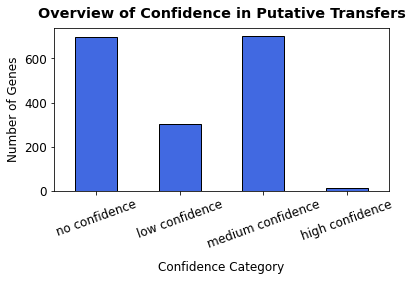

In [96]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

__author__ = 'Serafina Nieves'
__email__ = 'smnieves@ucsc.edu'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

geneprot_conv = {}
sample_selection = {"ERR034191": "poly-A", "SRR1015499": "poly-A", "SRR1015511": "poly-A", "SRR1324808": "mRNA enrichment",
                    "ERR3447770": "total RNA", "DRR118169": "total RNA", "DRR118173": "total RNA", "DRR118174": "total RNA",
                    "SRR8570229": "total RNA", "SRR5139361": "rRNA depletion", "DRR030156": "undetermined", "DRR030162": "undetermined",
                    "DRR030164": "undetermined", "DRR029092": "undetermined"}

def real_insertion(row):
    output = ""
#     try:
#         if row["cov_perc"] > 2.5 and row["cov_perc"] < 97.5:
#             real += 1
            
#     except(TypeError):
#         pass
    try:
        if float(row["cov_perc"]) > 2.5 and float(row["cov_perc"]) < 97.5:
            try:
                if int(row["intron_count"]) >= 1 or int(row["eukcds_on_contig"]) >= 1:
                    output = "medium confidence"
                    if int(row["intron_count"]) >= 1 and int(row["eukcds_on_contig"]) >= 1 or row["selection"] == "poly-A":
                        output = "high confidence"
                else:
                    output = "low confidence"
            except ValueError:
                print(row)
        else:
            output = "no confidence"
    except(ValueError):
        output = "no confidence"
        
    return output


for line in open("prot_gene_ids.txt", "r"):
    gene, prot = line.strip().split("\t")
    geneprot_conv[gene] = prot
    
print(geneprot_conv["gene-LSTR_LSTR015269"])

genomic_check = pd.read_csv("genomic_check.txt", engine="python", sep="\t", index_col=False, names=["chr", "gene_id", "cov_perc", "species"])
tpm_check = pd.read_csv("tpm_check.txt", engine="python", sep="\t", index_col = False, names=['chr', 'gene_id', 'tpm', 'species', 'sample'], header=None)
flank_check = pd.read_csv("flankgene_check.txt", engine="python", sep="\t", index_col=False, names=['acc', 'count', 'origin'])
intron_check = pd.read_csv("intron_check.txt", engine="python", sep="\t", index_col=False, names=['gene_id', 'intron_count'])

tpm_check["selection"] = tpm_check["sample"].map(sample_selection)
master_df = genomic_check.copy()
master_df["prot_id"] = master_df.apply(lambda row: geneprot_conv[row["gene_id"]], axis=1)


master_df = pd.merge(master_df, tpm_check, on=["chr", "gene_id","species"], how="left")
master_df = pd.merge(master_df, intron_check, on=["gene_id"], how="outer")
master_df = master_df[["species", "chr", "gene_id", "prot_id", "cov_perc", "tpm", "selection", "intron_count"]]
master_df.sort_values(["species", "chr", "gene_id"], inplace=True)
master_df.reset_index(drop=True, inplace=True)

contigGene_dict = {}

with open("flank_geneIDs.txt", "r") as flank_file:
    for line in flank_file:
        contig, gene, prot = line.strip().split("\t")
        #print(contig)
        contigGene_dict[prot] = contig

contigFlank_count = {key:0 for key in set(master_df["chr"])}

with open("flankgene_check.txt", "r") as flank_counts:
    for line in flank_counts:
        acc, count, origin = line.strip().split("\t")
        if origin == "Eukaryote":
            try:
                contigFlank_count[contigGene_dict[acc]] += 1
            except(KeyError):
                pass

master_df["eukcds_on_contig"] = master_df["chr"].apply(lambda x: contigFlank_count[x])
master_df.fillna("N/A", inplace=True)
master_df["real_insertion"] = master_df.apply(lambda x: real_insertion(x), axis=1)
candidates = set(master_df.loc[master_df["real_insertion"].isin(["high confidence", "medium confidence"])]["prot_id"])

counts = master_df["real_insertion"].value_counts().reindex(["no confidence", "low confidence", "medium confidence", "high confidence"])

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
ax = counts.plot.bar(x='lab', y='val', rot=20, linewidth=1, edgecolor="black", color="royalblue")

ax.set_title("Overview of Confidence in Putative Transfers", pad=10, loc="center", fontweight='bold')
ax.set_xlabel("Confidence Category", labelpad=10)
ax.set_ylabel("Number of Genes")

plt.savefig("confidence_barplot.png", dpi=300, bbox_inches = "tight")

print(master_df.groupby(['species', 'real_insertion']).size().reset_index(name='counts').set_index("species"))

with open ("candidates.txt", "w") as afile:
    for item in sorted(candidates):
        afile.write(item + "\n")
    

with open("master_list2.txt", "w") as outfile:
    outfile.write(master_df.to_csv(sep="\t", header=True))

print(len(set(master_df["prot_id"])))

# prot_here = set(master_df["prot_id"])
# for item in geneprot_conv.keys():
#     if item not in prot_here:
#         print(item)

## Finalizing Results (cont.)

#### Thursday 08/13/2020 - To-do List
Several things need to get done to finalize my gene list:
- [x] Be able to match the blast accessions back to a contig
- [x] Count number of eukaryotic genes per contig and add to master file
- [ ] Regenerate covcheck files using genes (not exons) and regenerated bed files
- [ ] Generate RNA-seq check files for a. vulgare
- [ ] Further investigation into selection methods

#### Tuesday 09/15/2020 - Adding Proteins to the Analysis
After reblasting updated refseq and genbank protein assemblies at my Wolbachia database (and fixing **FilterBlast.py**), i found potentially ~1000 more protein sequences. I am getting the taxids for these proteins, and then making species directories to run the above analysis on them.
Here is how I'm fetching the *taxids*:

In [ ]:
while read -r line
do
esearch -db protein -query line |esummary|xtract -pattern TaxId -element TaxId >> updated_taxids.txt
done < *acc

#### Wednesday 09/23/2020 - Doing above analysis by gene (not exon)
**Basura contains covcheck files generated by exon. Mermaid contains covcheck files (in scratch) generated by gene.** The master list needs to be regenerated so that we can view all info by gene. I believe the covcheck files are the only ones forcing the master list to read by exon instead of gene. Hopefully I don't need to update any code to handle genes (I don't think I'll need to). The updated CovCheck program is **CovCheck_genes.py**.

#### Monday 12/07/2020 - Information on updated BLAST and ProttoGene.py
So **ProttoGene.py** looks up the gene name for the protein in the GFF files. Below I will list any information about this more comprehensive BLAST run that I think is relevant:
 - Filtered by perc_id >= 80 and len_align >= 150
 - 31 assemblies had proteins that met these parameters against the Wolbachia database
| File                                                                               | Number of Unique BLASTp Hits |
|------------------------------------------------------------------------------------|------------------------------|
| GCA_000005115.1_dana_caf1_protein.faa.out.filtered                                 | 3                            |
| GCA_000208615.1_JCVI_ISG_i3_1.0_protein.faa.out.filtered                           | 4                            |
| GCA_001887335.1_A_vulgare_v1_protein.faa.out.filtered                              | 1224                         |
| GCA_002891405.2_Csec_1.0_protein.faa.out.filtered                                  | 2                            |
| GCA_003335185.2_ASM333518v2_protein.faa.out.filtered                               | 32                           |
| GCA_004104545.1_Arma_vul_BF2787_protein.faa.out.filtered                           | 13                           |
| GCA_004794745.1_tlon_1.0_protein.faa.out.filtered                                  | 1                            |
| GCA_013235015.1_Ave_3.0_protein.faa.out.filtered                                   | 5                            |
| GCA_013368085.1_Ate_protein.faa.out.filtered                                       | 58                           |
| GCA_902439185.1_CINCED3_protein.faa.out.filtered                                   | 121                          |
| GCF_000188075.2_Si_gnH_protein.faa.out.filtered 3                                  |                              |
| GCF_000204515.1_Aech_3.9_protein.faa.out.filtered                                  | 14                           |
| GCF_000236305.1_Drho_2.0_protein.faa.out.filtered                                  | 1                            |
| GCF_000236325.1_Deug_2.0_protein.faa.out.filtered                                  | 1                            |
| GCF_000475195.1_Diaci_psyllid_genome_assembly_version_1.1_protein.faa.out.filtered | 2                            |
| GCF_000949405.1_V.emery_V1.0_protein.faa.out.filtered                              | 173                          |
| GCF_000956235.1_wasmannia.A_1.0_protein.faa.out.filtered                           | 7                            |
| GCF_001594055.1_Tzet1.0_protein.faa.out.filtered                                   | 1                            |
| GCF_001594075.1_Tcor1.0_protein.faa.out.filtered                                   | 2                            |
| GCF_001652005.1_ASM165200v1_protein.faa.out.filtered                               | 3                            |
| GCF_001687245.1_Rhagoletis_zephyria_1.0_protein.faa.out.filtered                   | 24                           |
| GCF_002891405.2_Csec_1.0_protein.faa.out.filtered                                  | 2                            |
| GCF_003070985.1_ASM307098v1_protein.faa.out.filtered                               | 1                            |
| GCF_003268045.1_YSA_version1_protein.faa.out.filtered                              | 2                            |
| GCF_003285975.2_DanaRS2.1_protein.faa.out.filtered                                 | 1                            |
| GCF_003426905.1_ASM342690v1_protein.faa.out.filtered                               | 1                            |
| GCF_003651465.1_ASM365146v1_protein.faa.out.filtered                               | 21                           |
| GCF_003710045.1_USU_Nmel_1.2_protein.faa.out.filtered                              | 1                            |
| GCF_004153925.1_Obicornis_v3_protein.faa.out.filtered                              | 5                            |
| GCF_012274295.1_USDA_OLig_1.0_protein.faa.out.filtered                             | 2                            |
| GCF_902806685.1_iAphHyp1.1_protein.faa.out.filtered                                | 18                           |

In [ ]:
IDS = [ananassae, ananassae2, auropunctata, bicornis, calcarata, cedri, citri, clavipes,
cornetzi, curvispinosus, echinatior, elegans, emeryi, eugracilis, exsecta, felis, flava, hyperantus, invicta, lignaria,
longispinosus, melanderi, rhopaloa,secundus, striatellus, terminalis, ventricosus, vulgare, vulgare2, zephyria, zeteki]

rule all:
    expand("{directory}/{sra}.covcheck", directory=IDS.keys(), sra=IDS.values())
    
rule download_data:
    shell:
        "prefetch {sra} --max-size 60G"
        "fastq-dump --split-files --gzip {sra}"
        "rm ~/ncbi/public/sra/{sra}.sra"

rule create_bed:
    shell:
        "convert2bed -i gff -o bed < .gff > $ref.bed"

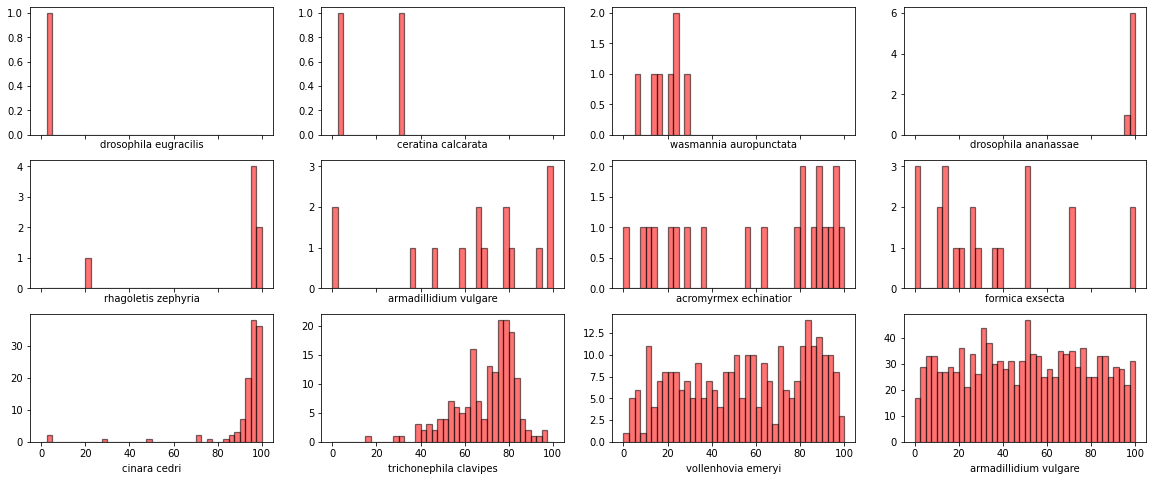

In [98]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

__author__ = 'Serafina Nieves'
__email__ = 'smnieves@ucsc.edu'

import pandas as pd
import argparse
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
import numpy as np
import os


speciesDict = {"SRR3458570.covcheck": "armadillidium vulgare", "ERR034187.covcheck": "acromyrmex echinatior", "SRR3458573.covcheck": "armadillidium vulgare", "ERR3437293.covcheck": "cinara cedri",
                   "SRR2912519.covcheck": "ceratina calcarata", "SRR2135644.covcheck": "drosophila ananassae", "SRR341538.covcheck": "drosophila eugracilis",
                   "DRR042089.covcheck": "formica exsecta", "SRR3680351.covcheck": "rhagoletis zephyria", "SRR7188756.covcheck": "sipha flava", "SRR621118.covcheck": "solenopsis invicta",
                   "SRR5139338.covcheck": "trichonephila clavipes", "DRR037409.covcheck": "vollenhovia emeryi", "DRR029092.covcheck": "wasmannia auropunctata", "SRR5830088.covcheck": "laodelphax striatellus"}

panel_num = 1
fig, subs = plt.subplots(3, 4, figsize=(20, 8), sharex=True)

covcheck_files = []
hist_list = []
for file in os.listdir("C:/Users/Serafina Nieves/Google Drive/Lab/Lab Work/Jupyter Lab/"):
    if file.endswith(".covcheck"):
        cov = pd.read_csv(file, sep='\t', header=0, names=['row', 'chr', 'id', 'region_len', 'total_cov', 'median_exon_cov', 'cov_percentile'])
        covcheck_files.append((file, cov['cov_percentile'].tolist()))
        
covcheck_files = sorted(covcheck_files[0:12], key=lambda x: len(x[1]))

num = 0
for i in range(0, 3):
    for j in range(0, 4):
        y, x, _ = subs[i][j].hist(covcheck_files[num][1], bins=np.arange(0, 102.5, 2.5), alpha=0.55, lw=1.25, color='red', edgecolor='black')
        subs[i][j].set_xlabel(speciesDict[covcheck_files[num][0]], labelpad=5)
        num+=1


#### Thursday 01/14/2021 - Redoing the Master List
I found it might be worth it to create a larger master list program so there aren't so many disjointed parts and incompatibility issues. I will do that below.